# Data Augmentation to improve accuracy:

In [ ]:
import random
import os
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]
def vertical_flip(image_array: ndarray):
    return image_array[::-1, :]

In [ ]:
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip,
    'vertical_flip':vertical_flip
}

In [ ]:
# our folder path containing some images
folder_path = '/Users/shijiazeng/Desktop/2moreroots'
# the number of file to generate
num_files_desired = 100

# loop on all files of the folder and build a list of files paths
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [ ]:
num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path,plugin='matplotlib')
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1
        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

# Split  Dataset  into Train and Validate:

In [ ]:
import glob, shutil, random, os
dirpath = '/Users/shijiazeng/Desktop/2moreroots'
dst_dir = '/Users/shijiazeng/Desktop/new'

filenames = random.sample(os.listdir(dirpath), 45)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    shutil.move(srcpath, dst_dir)

# Data Preprocessing:

In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping


RANDOM_SEED = 123

In [2]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [3]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [4]:
def plot_history(history):
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')

    plt.show()

In [5]:
TRAIN_DIR = '/Users/shijiazeng/Desktop/xrays_database/train/'
VAL_DIR = '/Users/shijiazeng/Desktop/xrays_database/validate/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 3/3 [00:00<00:00, 14.23it/s]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 3/3 [00:00<00:00, 38.92it/s]

212 images loaded from /Users/shijiazeng/Desktop/xrays_database/train/ directory.
90 images loaded from /Users/shijiazeng/Desktop/xrays_database/validate/ directory.


In [6]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 212 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


# Build Model:

In [8]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE+(3,)
)

In [9]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                3211296   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 26,799,041
Trainable params: 3,211,329
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[es]
)

Epoch 1/30
7/7 [==============================] - 13s 2s/step - loss: 1.3238 - accuracy: 0.6368 - val_loss: 0.4196 - val_accuracy: 0.8000
Epoch 2/30
7/7 [==============================] - 12s 2s/step - loss: 0.3305 - accuracy: 0.8443 - val_loss: 0.4547 - val_accuracy: 0.7667
Epoch 3/30
7/7 [==============================] - 12s 2s/step - loss: 0.2788 - accuracy: 0.8726 - val_loss: 0.2452 - val_accuracy: 0.8778
Epoch 4/30
7/7 [==============================] - 12s 2s/step - loss: 0.1831 - accuracy: 0.9104 - val_loss: 0.2076 - val_accuracy: 0.9333
Epoch 5/30
7/7 [==============================] - 12s 2s/step - loss: 0.1990 - accuracy: 0.9104 - val_loss: 0.1764 - val_accuracy: 0.9111
Epoch 6/30
7/7 [==============================] - 13s 2s/step - loss: 0.0913 - accuracy: 0.9717 - val_loss: 0.1685 - val_accuracy: 0.9333
Epoch 7/30
7/7 [==============================] - 13s 2s/step - loss: 0.3111 - accuracy: 0.8774 - val_loss: 0.1705 - val_accuracy: 0.9444
Epoch 8/30
7/7 [==================

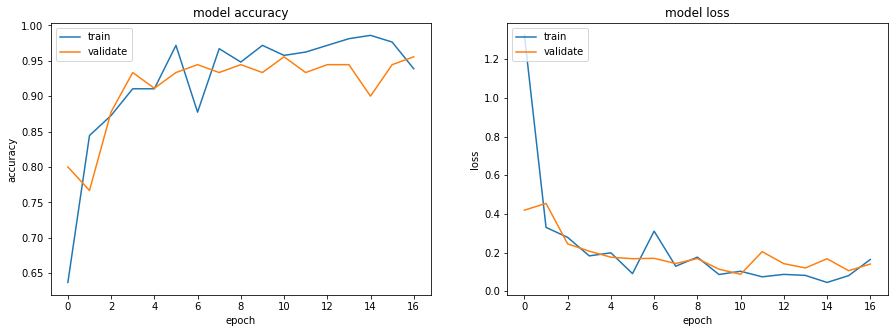

In [11]:
plot_history(history)

In [12]:
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

cm = confusion_matrix(y_val, predictions) 
print(cm)

Val Accuracy = 0.96
[[44  1]
 [ 3 42]]


In [18]:
llist = []
label = []
for path in sorted(os.listdir(VAL_DIR)):
    if not path.startswith('.'):
        for file in os.listdir(VAL_DIR + path):
            if not file.startswith('.'):
                llist.append(file) 
                label.append(path)

In [19]:
val_pred = ['1root' if x==0 else '2moreroots' for x in predictions]
pd.set_option('display.max_rows', None)
results = pd.DataFrame({"filename":llist, "true_label":label, "predict_label":val_pred})
print(results)

         filename  true_label predict_label
0    tooth_69.jpg       1root         1root
1    tooth_82.jpg       1root         1root
2    tooth_83.jpg       1root         1root
3     tooth_5.jpg       1root         1root
4     tooth_7.jpg       1root         1root
5    tooth_95.jpg       1root         1root
6    tooth_57.jpg       1root         1root
7    tooth_84.jpg       1root         1root
8    tooth_90.jpg       1root         1root
9     tooth_3.jpg       1root         1root
10   tooth_46.jpg       1root         1root
11    tooth_1.jpg       1root         1root
12   tooth_93.jpg       1root         1root
13   tooth_79.jpg       1root         1root
14  tooth_112.jpg       1root         1root
15  tooth_106.jpg       1root         1root
16  tooth_104.jpg       1root         1root
17   tooth_20.jpg       1root         1root
18   tooth_18.jpg       1root         1root
19  tooth_101.jpg       1root         1root
20  tooth_100.jpg       1root         1root
21  tooth_128.jpg       1root   